## 1. Import Packages

In [1]:
import os
import cv2
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import load_model, Model
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import plot_model
from PIL import ImageFont, ImageDraw, Image
%matplotlib inline

## 2. GPU Available and Device Check

In [2]:
print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16070904456369312708
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648653952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9055292658684852081
physical_device_desc: "device: 0, name: NVIDIA Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5"
]


## 3. Dataset
  - DeepFashion (Category and Attribute Prediction Benchmark)
    - http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion/AttributePrediction.html

In [3]:
# DeepFashion Dataset Path
dataset_path = '/data/Deepfashion'
train_path = dataset_path + '/train'
validation_path = dataset_path + '/validation'
test_path = dataset_path + '/test'

## 4. Parameters & Hyperparameters

In [4]:
img_row, img_col, img_channel = 224, 224, 3
batch_size_train = 64
batch_size_validation = 64
epochs = 10
category_nums = 22
drop_rate = 0.4
learning_rate = 0.0001
momentum_num = 0.99

## 5. EDA

### 5 - 1. ImageDataGenerator Debugging

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode='nearest'
)

img = load_img(dataset_path + '/train/Top/Collared_Woven_Top_img_00000001_gt_98-60-200-239_iou_1.0.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in train_datagen.flow(x, batch_size=1,
                         save_to_dir='/home/azure/passion/AI/Demo/image_debugging',
                         save_prefix='top',
                         save_format='jpg'
                         ):
    i += 1
    if i>20:
        break

In [6]:
debugging_img_list = os.listdir('/home/azure/passion/AI/Demo/image_debugging')
print(debugging_img_list)

['top_0_5055.jpg', 'top_0_402.jpg', 'top_0_2237.jpg', 'top_0_7061.jpg', 'top_0_6555.jpg', 'top_0_5540.jpg', 'top_0_8132.jpg', 'top_0_8961.jpg', 'top_0_9275.jpg', 'top_0_5934.jpg', 'top_0_3162.jpg', 'top_0_9857.jpg', 'top_0_7879.jpg', 'top_0_5011.jpg', 'top_0_9912.jpg', 'top_0_2893.jpg', 'top_0_732.jpg', 'top_0_9594.jpg', 'top_0_1677.jpg', 'top_0_9723.jpg', 'top_0_3791.jpg']


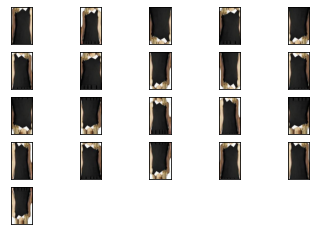

In [7]:
fig = plt.figure()
rows = 5
cols = 5
i = 1
debugging_img_path = '/home/azure/passion/AI/Demo/image_debugging'

for filename in debugging_img_list:
    img = cv2.imread(debugging_img_path + '/' + filename)
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_xticks([]), ax.set_yticks([])
    i += 1

plt.show()

### 5 - 2. Data Load

In [8]:
def data_load(train_path, validation_path, test_path, batch_size_train, batch_size_validation, img_row, img_col):

    # Train
    imgdatagen_train = ImageDataGenerator(
        rescale=1./255
    )

    train_dataset = imgdatagen_train.flow_from_directory(
        train_path,
        target_size=(img_row, img_col),
        batch_size=batch_size_train,
        class_mode='categorical',
        shuffle=True
    )

    # Validation
    imgdatagen_validatioin = ImageDataGenerator(
        rescale=1./255
    )

    validation_dataset = imgdatagen_validatioin.flow_from_directory(
        validation_path,
        target_size=(img_row, img_col),
        batch_size=batch_size_validation,
        class_mode='categorical',
        shuffle=True
    )

    # Test
    imgdatagen_test = ImageDataGenerator(
        rescale=1./255
    )
    
    test_dataset = imgdatagen_test.flow_from_directory(
        test_path,
        target_size=(img_row, img_col),
        class_mode='categorical',
        shuffle=False
    )
    
    return train_dataset, validation_dataset, test_dataset

In [9]:
train_dataset, validation_dataset, test_dataset = data_load(train_path, validation_path, test_path, batch_size_train, batch_size_validation, img_row, img_col)

X_train, y_train = next(train_dataset)

print(X_train.shape)
print(y_train.shape)
print(y_train[1,:])

X_val, y_val = next(validation_dataset)

print(X_val.shape)
print(y_val.shape)

X_test, y_test = next(test_dataset)

print(X_test.shape)
print(y_test.shape)

Found 204406 images belonging to 23 classes.
Found 39055 images belonging to 23 classes.
Found 39065 images belonging to 23 classes.
(64, 224, 224, 3)
(64, 23)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(64, 224, 224, 3)
(64, 23)
(32, 224, 224, 3)
(32, 23)


### 5 - 3. Data visualization - train dataset

class indices of train dataset:  {'Blazer': 0, 'Blouse': 1, 'Cardigan': 2, 'Coat': 3, 'Cutoffs': 4, 'Dress': 5, 'Hoodie': 6, 'Jacket': 7, 'Jeans': 8, 'Joggers': 9, 'Jumpsuit': 10, 'Leggings': 11, 'Parka': 12, 'Poncho': 13, 'Romper': 14, 'Shirts': 15, 'Shorts': 16, 'Skirt': 17, 'Sweater': 18, 'Tank': 19, 'Tee': 20, 'Top': 21, 'Trunks': 22}

Sorted category nums of train dataset:  [('Dress', 52137), ('Tee', 26652), ('Blouse', 19524), ('Shorts', 14194), ('Tank', 11203), ('Skirt', 10793), ('Sweater', 9615), ('Cardigan', 9605), ('Jacket', 7897), ('Top', 7269), ('Jeans', 5568), ('Romper', 5424), ('Blazer', 5407), ('Jumpsuit', 4463), ('Leggings', 3570), ('Joggers', 3259), ('Hoodie', 2909), ('Coat', 1601), ('Cutoffs', 1176), ('Shirts', 763), ('Poncho', 578), ('Parka', 490), ('Trunks', 286)]

Total train dataset nums:  204383



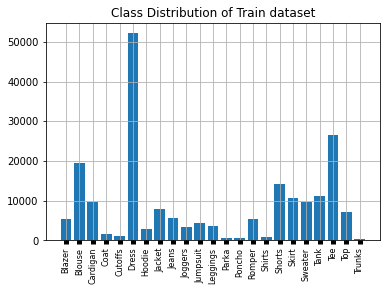

In [10]:
# Class Distribution of Train dataset
train_dataset_class_indices = train_dataset.class_indices
print("class indices of train dataset: ",train_dataset_class_indices)

category_nums = {}

for filename in train_dataset.filenames:
    class_name = filename.split('/')[0]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


print()       
print("Sorted category nums of train dataset: ", sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print()
print("Total train dataset nums: ", sum(category_nums.values()))
print()
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of Train dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

### 5 - 4. Data visualization - validation dataset

class indices of validation dataset:  {'Blazer': 0, 'Blouse': 1, 'Cardigan': 2, 'Coat': 3, 'Cutoffs': 4, 'Dress': 5, 'Hoodie': 6, 'Jacket': 7, 'Jeans': 8, 'Joggers': 9, 'Jumpsuit': 10, 'Leggings': 11, 'Parka': 12, 'Poncho': 13, 'Romper': 14, 'Shirts': 15, 'Shorts': 16, 'Skirt': 17, 'Sweater': 18, 'Tank': 19, 'Tee': 20, 'Top': 21, 'Trunks': 22}

Sorted category nums of validation dataset:  [('Dress', 10051), ('Tee', 5142), ('Blouse', 3725), ('Shorts', 2699), ('Tank', 2096), ('Skirt', 2045), ('Sweater', 1839), ('Cardigan', 1827), ('Jacket', 1529), ('Top', 1396), ('Jeans', 1051), ('Blazer', 1039), ('Romper', 988), ('Jumpsuit', 839), ('Leggings', 717), ('Joggers', 580), ('Hoodie', 540), ('Coat', 293), ('Cutoffs', 248), ('Shirts', 129), ('Poncho', 105), ('Parka', 97), ('Trunks', 57)]

Total validation dataset nums:  39032



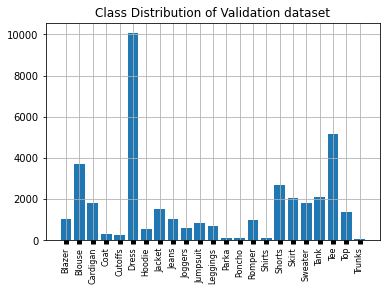

In [11]:
# Class Distribution of validation dataset
validation_dataset_class_indices = validation_dataset.class_indices
print("class indices of validation dataset: ", validation_dataset_class_indices)

category_nums = {}

for filename in validation_dataset.filenames:
    class_name = filename.split('/')[0]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


print()       
print("Sorted category nums of validation dataset: ", sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print()
print("Total validation dataset nums: ", sum(category_nums.values()))
print()
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of Validation dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

### 5 - 5. Data visualization - test dataset

class indices of test dataset:  {'Blazer': 0, 'Blouse': 1, 'Cardigan': 2, 'Coat': 3, 'Cutoffs': 4, 'Dress': 5, 'Hoodie': 6, 'Jacket': 7, 'Jeans': 8, 'Joggers': 9, 'Jumpsuit': 10, 'Leggings': 11, 'Parka': 12, 'Poncho': 13, 'Romper': 14, 'Shirts': 15, 'Shorts': 16, 'Skirt': 17, 'Sweater': 18, 'Tank': 19, 'Tee': 20, 'Top': 21, 'Trunks': 22}

Sorted category nums of test dataset:  [('Dress', 9967), ('Tee', 5090), ('Blouse', 3779), ('Shorts', 2770), ('Tank', 2127), ('Skirt', 1932), ('Cardigan', 1876), ('Sweater', 1812), ('Jacket', 1507), ('Top', 1410), ('Jeans', 1048), ('Blazer', 1046), ('Romper', 993), ('Jumpsuit', 848), ('Leggings', 723), ('Hoodie', 596), ('Joggers', 574), ('Coat', 320), ('Cutoffs', 242), ('Shirts', 151), ('Poncho', 105), ('Parka', 86), ('Trunks', 40)]

Total test dataset nums:  39042



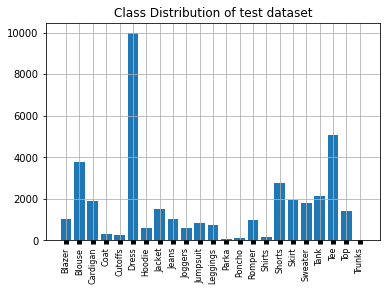

In [12]:
# Class Distribution of test dataset

test_dataset_class_indices = test_dataset.class_indices
print("class indices of test dataset: ", test_dataset_class_indices)

category_nums = {}

for filename in test_dataset.filenames:
    class_name = filename.split('/')[0]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


print()       
print("Sorted category nums of test dataset: ", sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print()
print("Total test dataset nums: ", sum(category_nums.values()))

print()
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of test dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

### 5 - 6. Summary

In [13]:
class_labels = list(train_dataset.class_indices.keys())
num_imgs_validation = len(validation_dataset.filenames)
num_imgs_train = len(train_dataset.filenames)
num_imgs_test = len(test_dataset.filenames)
print("class_labels_keys: ", class_labels)
print("Length of class_labels: ", len(class_labels))
print("Number of train images: ", num_imgs_train)
print("Number of validation images: ", num_imgs_validation)
print("Number of test images: ", num_imgs_test)

class_labels_keys:  ['Blazer', 'Blouse', 'Cardigan', 'Coat', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit', 'Leggings', 'Parka', 'Poncho', 'Romper', 'Shirts', 'Shorts', 'Skirt', 'Sweater', 'Tank', 'Tee', 'Top', 'Trunks']
Length of class_labels:  23
Number of train images:  204406
Number of validation images:  39055
Number of test images:  39065


### 6. Train dataset undersampling using Object Detection Model
    - 시간이 너무 오래걸림

In [14]:
# print(os.getcwd())

In [15]:
# image_path = '/home/azure/passion/AI/CategoryandAttributePredictionBenchmark/static/shirtsshorts.jpg'
# labelsPath = '/home/azure/passion/AI/YOLOv3/deepfashion2yolov3model/df2.names'
# weightsPath = '/home/azure/passion/AI/YOLOv3/deepfashion2yolov3model/yolov3-df2_15000.weights'
# configPath = '/home/azure/passion/AI/YOLOv3/deepfashion2yolov3model/yolov3-df2.cfg'

In [16]:
# def object_detection(image_path, labelsPath, weightsPath, configPath):

#     # YOLO 라벨(Clothes)
#     YOLO_LABELS = open(labelsPath).read().strip().split("\n")

#     # YOLO 모델 호출
#     yolo_net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

#     # YOLO 출력층 설정
#     layer_names = yolo_net.getLayerNames()
#     output_layers = [layer_names[i[0] - 1] for i in yolo_net.getUnconnectedOutLayers()]
#     colors = np.random.uniform(0, 255, size=(len(YOLO_LABELS), 3))

#     # 영상 할당
#     file_path = image_path
#     cap = cv2.VideoCapture(file_path)

#     # 화면 폰트
#     font = cv2.FONT_HERSHEY_SIMPLEX

#     _, frame = cap.read()
#     height, width, channels = frame.shape

#     # Detecting objects
#     blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

#     yolo_net.setInput(blob)
#     outs = yolo_net.forward(output_layers)

#     # Showing informations on the screen
#     count = 0
#     class_ids = []
#     confidences = []
#     boxes = []
#     crop_labels = []
#     for out in outs:
#         for detection in out:
#             # print(detection)
#             scores = detection[5:]
#             class_id = np.argmax(scores)
#             confidence = scores[class_id]
#             if confidence > 0.5:
#                 count += 1
#                 # Object detected
#                 # center_x = int(detection[0] * width)
#                 # center_y = int(detection[1] * height)
#                 # ww = int(detection[2] * width)
#                 # hh = int(detection[3] * height)

#                 # Rectangle coordinates
#                 # xx = int(center_x - ww / 2)
#                 # yy = int(center_y - hh / 2)

#                 # boxes.append([xx, yy, ww, hh])
#                 confidences.append(float(confidence))
#                 # class_ids.append(class_id)

#                 # object detection된 이미지의 object detection label
#                 crop_label = YOLO_LABELS[class_id]
#                 print(crop_label)
#                 # print(confidence)

#                 # object detection된 이미지 중 label이 중복된 값이 있다면 confidence가 높은 이미지 채택
#                 # crop_labels.append(crop_label)

#                 # crop_img = frame[yy:yy + hh, xx:xx + hh]
                
#                 if crop_label == 'short_sleeve_dress':
#                     # cv2.imwrite('/home/azure/passion/AI/Demo/tmp/' +  crop_label + "_" + str(count) + "_" + str(confidence) + ".jpg", crop_img)
#                     # print(crop_label)                
#                     return crop_label
#                 elif crop_label == 'long_sleeve_dress':
#                     # cv2.imwrite('/home/azure/passion/AI/Demo/tmp/' +  crop_label + "_" + str(count) + "_" + str(confidence) + ".jpg", crop_img)
#                     # print(crop_label)                
#                     return crop_label
#                 elif crop_label == 'vest_dress':
#                     # cv2.imwrite('/home/azure/passion/AI/Demo/tmp/' +  crop_label + "_" + str(count) + "_" + str(confidence) +  ".jpg", crop_img)
#                     # print(crop_label)                
#                     return crop_label
#                 elif crop_label == 'sling_dress':
#                     # cv2.imwrite('/home/azure/passion/AI/Demo/tmp/' +  crop_label + "_" + str(count) + "_" + str(confidence) +  ".jpg", crop_img)
#                     # print(crop_label)                
#                     return crop_label
#                 else:
#                     continue

In [17]:
# train_paths = []

# for f in glob.glob(train_path + '/' + 'Dress' + '/*.jpg'):
#     train_paths.append(f)

# print(train_paths[:1])

In [18]:
# dress_labeled_path = []
# for path in train_paths:
#     label = object_detection(path, labelsPath, weightsPath, configPath)
#     if label == 'short_sleeve_dress':
#         dress_labeled_path.append(path)
#     elif label == 'long_sleeve_dress':
#         dress_labeled_path.append(path)
#     elif label == 'vest_dress':
#         dress_labeled_path.append(path)
#     elif label == 'sling_dress':
#         dress_labeled_path.append(path)

# print(len(dress_labeled_path))

### 7. Train Data Oversampling & Undersampling

In [19]:
# class_names = ['Blazer', 'Blouse', 'Cardigan', 'Coat', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit', 'Leggings', 'Parka', 'Poncho', 'Romper', 'Shirts', 'Shorts', 'Skirt', 'Sweater', 'Tank', 'Tee', 'Top', 'Trunks']
# print(len(class_names))
# train_paths = []

# for cls in class_names:
#     for f in glob.glob(train_path + '/' + cls + '/*.jpg'):
#         if cls == 'Dress':
#             train_paths.append(f)
#         elif cls == 'Trunks':
#             for i in range(34):
#                 train_paths.append(f)
#         elif cls == 'Shirts':
#             for i in range(13):
#                 train_paths.append(f)
#         elif cls == 'Parka':
#             for i in range(20):
#                 train_paths.append(f)
#         elif cls == 'Cutoffs':
#             for i in range(8):
#                 train_paths.append(f)
#         elif cls == 'Coat':
#             for i in range(6):
#                 train_paths.append(f)
#         elif cls == 'Jeans':
#             for i in range(2):
#                 train_paths.append(f)
#         elif cls == 'Joggers':
#             for i in range(3):
#                 train_paths.append(f)
#         elif cls == 'Hoodie':
#             for i in range(2):
#                 train_paths.append(f)
#         elif cls == 'Leggings' or cls == 'Jumpsuit' or cls == 'Romper' or cls == 'Blazer':
#             for i in range(2):
#                 train_paths.append(f)
#         elif cls == 'Top' or cls == 'Jacket' or cls == 'Sweater' or cls == 'Cardigan' or cls == 'Skirt' or cls == 'Tank' or cls == 'Shorts' or cls == 'Tee' or cls == 'Blouse':
#             train_paths.append(f)

# print(train_paths[0])
# print(len(train_paths))

# train_paths_class = []

# for cls in class_names:
#     for f in glob.glob(train_path + '/' + cls + '/*.jpg'):
#         if cls == 'Dress':
#             train_paths_class.append(f.split('/')[4])
#         elif cls == 'Trunks':
#             for i in range(34):
#                 train_paths_class.append(f.split('/')[4])
#         elif cls == 'Shirts':
#             for i in range(13):
#                 train_paths_class.append(f.split('/')[4])
#         elif cls == 'Parka':
#             for i in range(20):
#                 train_paths_class.append(f.split('/')[4])
#         elif cls == 'Cutoffs':
#             for i in range(8):
#                 train_paths_class.append(f.split('/')[4])
#         elif cls == 'Coat':
#             for i in range(6):
#                 train_paths_class.append(f.split('/')[4])
#         elif cls == 'Jeans':
#             for i in range(2):
#                 train_paths_class.append(f.split('/')[4])
#         elif cls == 'Joggers':
#             for i in range(3):
#                 train_paths_class.append(f.split('/')[4])
#         elif cls == 'Hoodie':
#             for i in range(2):
#                 train_paths_class.append(f.split('/')[4])
#         elif cls == 'Leggings' or cls == 'Jumpsuit' or cls == 'Romper' or cls == 'Blazer':
#             for i in range(2):
#                 train_paths_class.append(f.split('/')[4])
#         elif cls == 'Top' or cls == 'Jacket' or cls == 'Sweater' or cls == 'Cardigan' or cls == 'Skirt' or cls == 'Tank' or cls == 'Shorts' or cls == 'Tee' or cls == 'Blouse':
#             train_paths_class.append(f.split('/')[4])        

# print(train_paths_class[0])
# print(len(train_paths_class))

# train_df = {'filepath': train_paths, 'class_name': train_paths_class}
# df_train = pd.DataFrame(train_df)
# print(df_train.head())

# train_csv_path = '/home/azure/passion/AI/Demo/sampling_dataframe/demotrain.csv'
# df_train.to_csv(train_csv_path)

In [20]:
train_csv_path = '/home/azure/passion/AI/Demo/sampling_dataframe/demotrain.csv'
train_df = pd.read_csv(train_csv_path)
train_df.head()

,Unnamed: 0,filepath,class_name
0,0,/data/Deepfashion/train/Blazer/Single-Button_B...,Blazer
1,1,/data/Deepfashion/train/Blazer/Single-Button_B...,Blazer
2,2,/data/Deepfashion/train/Blazer/Single-Button_B...,Blazer
3,3,/data/Deepfashion/train/Blazer/Single-Button_B...,Blazer
4,4,/data/Deepfashion/train/Blazer/Single-Button_B...,Blazer


In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='class_name',
    target_size=(img_row, img_col),
    batch_size=batch_size_train
)

Found 222107 validated image filenames belonging to 22 classes.


In [22]:
category_nums = {}

print(train_generator.filenames[0].split('/')[4])

for filename in train_generator.filenames:
    class_name = filename.split('/')[4]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


# print(category_nums)        
print(sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(category_nums.values()))

Blazer
[('Dress', 14336), ('Shorts', 14194), ('Blouse', 12522), ('Tee', 11651), ('Tank', 11203), ('Jeans', 11137), ('Romper', 10849), ('Blazer', 10815), ('Skirt', 10793), ('Shirts', 9931), ('Parka', 9819), ('Joggers', 9779), ('Trunks', 9757), ('Sweater', 9615), ('Coat', 9611), ('Cardigan', 9605), ('Cutoffs', 9415), ('Jumpsuit', 8927), ('Jacket', 7897), ('Top', 7269), ('Leggings', 7141), ('Hoodie', 5819)]
222085


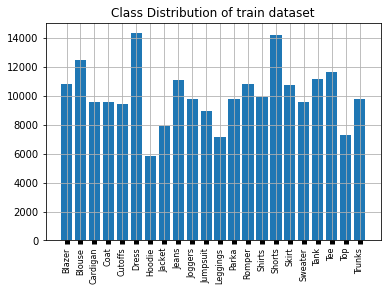

In [23]:
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of train dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

# Blouse -= 7000
# Dress -= 38000
# Tee -= 15000

### 8. Validation dataset Dress Category Undersampling

In [24]:
# class_names = ['Blazer', 'Blouse', 'Cardigan', 'Coat', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit', 'Leggings', 'Parka', 'Poncho', 'Romper', 'Shirts', 'Shorts', 'Skirt', 'Sweater', 'Tank', 'Tee', 'Top', 'Trunks']

# validation_paths = []

# for cls in class_names:
#     for f in glob.glob(validation_path + '/' + cls + '/*.jpg'):
#         if cls != 'Poncho':
#             validation_paths.append(f)

# print(validation_paths[0])
# print(len(validation_paths))

# validation_paths_class = []

# for cls in class_names:
#     for f in glob.glob(validation_path + '/' + cls + '/*.jpg'):
#         if cls != 'Poncho':
#             validation_paths_class.append(f.split('/')[4])
        

# print(validation_paths_class[0])
# print(len(validation_paths_class))

# validation_df = {'filepath': validation_paths, 'class_name': validation_paths_class}
# df_validation = pd.DataFrame(validation_df)
# print(df_validation.head())

# validation_csv_path = '/home/azure/passion/AI/CategoryandAttributePredictionBenchmark/dataset/sampling_dataframe/demovalidation.csv'
# df_validation.to_csv(validation_csv_path)

In [25]:
validation_csv_path = '/home/azure/passion/AI/Demo/sampling_dataframe/demovalidation.csv'
validation_df = pd.read_csv(validation_csv_path)
validation_df.head()

,Unnamed: 0,filepath,class_name
0,0,/data/Deepfashion/validation/Blazer/Single-But...,Blazer
1,1,/data/Deepfashion/validation/Blazer/Single-But...,Blazer
2,2,/data/Deepfashion/validation/Blazer/Single-But...,Blazer
3,3,/data/Deepfashion/validation/Blazer/Single-But...,Blazer
4,4,/data/Deepfashion/validation/Blazer/Single-But...,Blazer


In [26]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    x_col='filepath',
    y_col='class_name',
    target_size=(img_row, img_col),
    batch_size=batch_size_validation
)

Found 33948 validated image filenames belonging to 22 classes.


In [27]:
category_nums = {}

print(validation_generator.filenames[0].split('/')[4])

for filename in validation_generator.filenames:
    class_name = filename.split('/')[4]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


# print(category_nums)        
print(sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(category_nums.values()))

Blazer
[('Tee', 5142), ('Dress', 5050), ('Blouse', 3725), ('Shorts', 2699), ('Tank', 2096), ('Skirt', 2045), ('Sweater', 1839), ('Cardigan', 1827), ('Jacket', 1529), ('Top', 1396), ('Jeans', 1051), ('Blazer', 1039), ('Romper', 988), ('Jumpsuit', 839), ('Leggings', 717), ('Joggers', 580), ('Hoodie', 540), ('Coat', 293), ('Cutoffs', 248), ('Shirts', 129), ('Parka', 97), ('Trunks', 57)]
33926


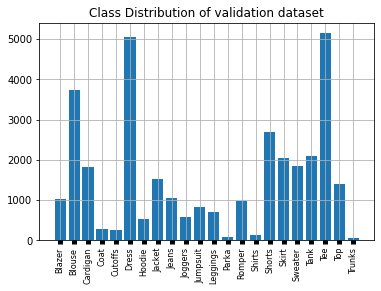

In [28]:
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of validation dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

### 9. Test dataset Dress Category Undersampling

In [29]:
# class_names = ['Blazer', 'Blouse', 'Cardigan', 'Coat', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit', 'Leggings', 'Parka', 'Poncho', 'Romper', 'Shirts', 'Shorts', 'Skirt', 'Sweater', 'Tank', 'Tee', 'Top', 'Trunks']

# test_paths = []

# for cls in class_names:
#     for f in glob.glob(test_path + '/' + cls + '/*.jpg'):
#         if cls != 'Poncho':
#             test_paths.append(f)

# print(test_paths[0])
# print(len(test_paths))

# test_paths_class = []

# for cls in class_names:
#     for f in glob.glob(test_path + '/' + cls + '/*.jpg'):
#         if cls != 'Poncho':
#             test_paths_class.append(f.split('/')[4])        

# print(test_paths_class[0])
# print(len(test_paths_class))

# test_df = {'filepath': test_paths, 'class_name': test_paths_class}
# df_test = pd.DataFrame(test_df)
# print(df_test.head())

# test_csv_path = '/home/azure/passion/AI/CategoryandAttributePredictionBenchmark/dataset/sampling_dataframe/demotest.csv'
# df_test.to_csv(test_csv_path)

In [30]:
test_csv_path = '/home/azure/passion/AI/Demo/sampling_dataframe/demotest.csv'
test_df = pd.read_csv(test_csv_path)
test_df.head()

,Unnamed: 0,filepath,class_name
0,0,/data/Deepfashion/test/Blazer/Single-Button_Bl...,Blazer
1,1,/data/Deepfashion/test/Blazer/Single-Button_Bl...,Blazer
2,2,/data/Deepfashion/test/Blazer/Single-Button_Bl...,Blazer
3,3,/data/Deepfashion/test/Blazer/Single-Button_Bl...,Blazer
4,4,/data/Deepfashion/test/Blazer/Single-Button_Bl...,Blazer


In [31]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='class_name',
    target_size=(img_row, img_col)
)

Found 33958 validated image filenames belonging to 22 classes.


In [32]:
category_nums = {}

print(test_generator.filenames[0].split('/')[4])

for filename in test_generator.filenames:
    class_name = filename.split('/')[4]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


# print(category_nums)        
print(sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(category_nums.values()))

Blazer
[('Tee', 5090), ('Dress', 4966), ('Blouse', 3779), ('Shorts', 2770), ('Tank', 2127), ('Skirt', 1932), ('Cardigan', 1876), ('Sweater', 1812), ('Jacket', 1507), ('Top', 1410), ('Jeans', 1048), ('Blazer', 1046), ('Romper', 993), ('Jumpsuit', 848), ('Leggings', 723), ('Hoodie', 596), ('Joggers', 574), ('Coat', 320), ('Cutoffs', 242), ('Shirts', 151), ('Parka', 86), ('Trunks', 40)]
33936


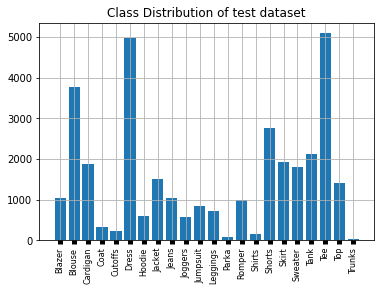

In [33]:
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of test dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

### 10. Sampling Summary

In [34]:
class_labels_sampling = list(train_generator.class_indices.keys())
print("class labels sampling keys: ", class_labels_sampling)
print("The number of class labels: ", len(class_labels_sampling))
num_imgs_train_sampling = len(train_generator.filenames)
print("The number of train images sampling: ", num_imgs_train_sampling)
num_imgs_validation_sampling = len(validation_generator.filenames)
print("The number of validation images sampling: ", num_imgs_validation_sampling)
num_imgs_test_sampling = len(test_generator.filenames)
print("The number of testimages sampling: ", num_imgs_test_sampling)

class labels sampling keys:  ['Blazer', 'Blouse', 'Cardigan', 'Coat', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit', 'Leggings', 'Parka', 'Romper', 'Shirts', 'Shorts', 'Skirt', 'Sweater', 'Tank', 'Tee', 'Top', 'Trunks']
The number of class labels:  22
The number of train images sampling:  222107
The number of validation images sampling:  33948
The number of testimages sampling:  33958


### 11. VGG Model Building

In [35]:
# Initialize the Resnet50 model
resnet50_conv = ResNet50(
    weights='imagenet',
    input_shape=(img_row, img_col, img_channel),
    include_top=False,
    pooling='avg'
)

for layer in resnet50_conv.layers[:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in resnet50_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7febccb26390> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7febcca9fe10> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7febcd0e3208> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7febcca262e8> True
<tensorflow.python.keras.layers.core.Activation object at 0x7febcc1ce6d8> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7febcc1dedd8> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7febcc1e2860> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7febcc1e9b00> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7febcc1f8358> True
<tensorflow.python.keras.layers.core.Activation object at 0x7febcc180978> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7febcc189f60> True
<tensorflow.python.keras.layers.normaliz

In [43]:
# ResNet50
x = resnet50_conv.output
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
y = Dense(22, activation='softmax')(x)

model = Model(inputs=resnet50_conv.input,
             outputs=[y])

In [44]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

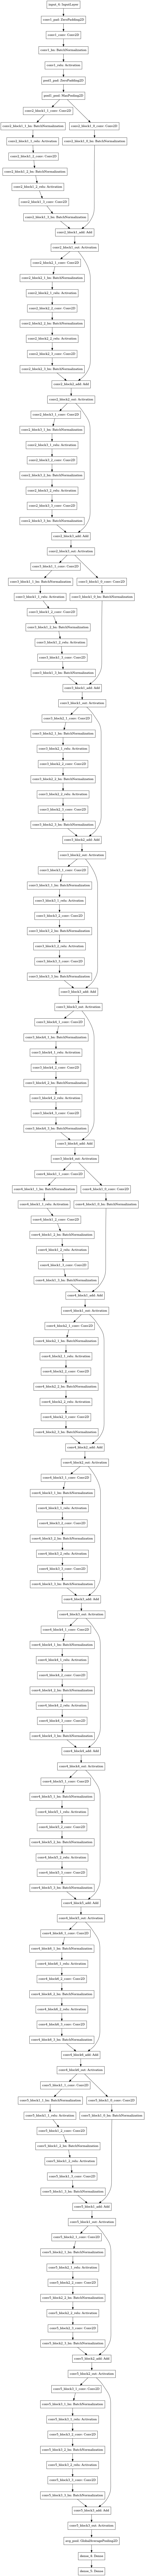

In [45]:
# Show a summary of the model
plot_model(model, to_file='/home/azure/passion/AI/Demo/output/model_summary/resnet50_demo_model.jpg')

In [46]:
opt = SGD(lr=0.0001, momentum=0.9, nesterov=True)

In [47]:
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_k_categorical_accuracy']
)

### 12. Plotting Accuracy & Loss Curves

In [48]:
def curves(model_histories, epochs):

    acc = model_histories.history['accuracy']
    top_5_categorical_accuracy = model_histories.history['top_k_categorical_accuracy']
    val_acc = model_histories.history['val_accuracy']
    val_top_5_categorical_accuracy = model_histories.history['val_top_k_categorical_accuracy']
    loss = model_histories.history['loss']
    val_loss = model_histories.history['val_loss']

    # Plot
    plt.plot(range(epochs), acc, 'mo', label='Training accuracy')
    plt.plot(range(epochs), val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Demo/output/plot/resnet50_model_accuracy.jpg')

    plt.figure()
    plt.plot(range(epochs), loss, 'mo', label='Training loss')
    plt.plot(range(epochs), val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Demo/output/plot/resnet50_model_loss.jpg')
    
    plt.figure()
    plt.plot(range(epochs), top_5_categorical_accuracy, 'mo', label='Training top 5 categorical accuracy')
    plt.plot(range(epochs), val_top_5_categorical_accuracy, 'b', label='Validation top 5 categorical accuracy')
    plt.title('Training and validation top 5 catagorical accuracy')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Demo/output/plot/resnet50_model_top_5_accuracy.jpg')
    plt.show()

### 13. Register Callbacks

In [49]:
def callback():
    
    # CSVLogger
    filename = '/home/azure/passion/AI/Demo/output/csv_logger/resnet50_model.csv'
    csv_log = tf.keras.callbacks.CSVLogger(
        filename, 
        separator=' ', 
        append=False
    )
    
    # EarlyStopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=300, 
        verbose=1, 
        mode='min'
    )
    
    # ReduceLRonPlateau
    lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        patience=20,
        factor=0.5,
        verbose=1
    )
    
    # ModelCheckpoint
    check_point = tf.keras.callbacks.ModelCheckpoint(
        filepath='/home/azure/passion/AI/Demo/output/checkpoint/resnet50__model.ckpt',
        save_best_only=True, save_weights_only=True, monitor='val_loss'
    )
    
    callback_list = [csv_log, early_stopping, lr_reducer, check_point]
    return callback_list

In [50]:
callback_list = callback()

### 14. Fine-tune the model - Training

In [51]:
def fit_model(model, train_generator, validation_generator, batch_size_train, batch_size_validation, epochs):
    
    history = model.fit(
        train_generator,
        epochs=epochs,
        steps_per_epoch=num_imgs_train_sampling//batch_size_train,
        validation_data=validation_generator,
        workers=0,
        verbose=1,
        callbacks=callback_list
    )

    score = model.evaluate(
        validation_generator,
        verbose=1
    )

    return model, history, score

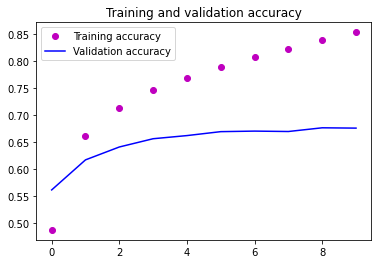

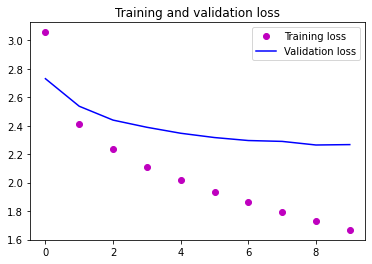

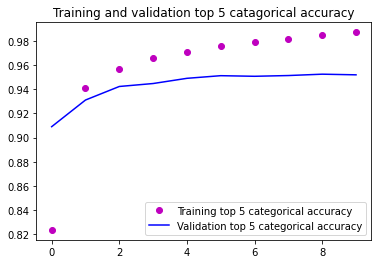

Validation Accuracy:0.6755626201629639 
Validation Loss:2.267223596572876
Validation Top 5 categorical accuracy: 0.9518086314201355


In [54]:
# model, history, score = fit_model(model, train_generator, validation_generator, batch_size_train, batch_size_validation, epochs)

# Learning curves
curves(history, epochs)
print('Validation Accuracy:{} \nValidation Loss:{}'.format(score[1] ,score[0]))
print('Validation Top 5 categorical accuracy: {}'.format(score[2]))
# Model Save
model.save('/home/azure/passion/AI/Demo/output/resnet50_model.h5')

### 15. Prediction

In [27]:
model.load_weights('/home/azure/passion/AI/Demo/output/checkpoint/resnet50_model.ckpt')
evaluation = model.evaluate(validation_generator)
print(evaluation)

In [28]:
testY_labels = test_generator.labels
print(testY_labels)
print(len(testY_labels))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [31]:
# validation
# model.load_weights('/home/azure/passion/AI/Demo/output/checkpoint/demo_model.ckpt')
Y_pred = model.predict(validation_generator)
print(Y_pred)
valY_labels = validation_generator.labels
print(valY_labels)
print(len(valY_labels))

[[4.94517267e-01 1.78471906e-03 4.53907065e-02 ... 1.27295982e-02
  2.67039449e-03 1.46962475e-05]
 [1.87276921e-03 3.37258144e-03 1.36001091e-02 ... 3.48586030e-02
  6.32186560e-03 8.84099281e-04]
 [5.24684367e-08 3.14881916e-08 1.08902514e-08 ... 6.84376218e-08
  3.19123430e-08 5.11376711e-05]
 ...
 [2.96695414e-03 3.91353096e-04 3.53036146e-03 ... 1.31941233e-02
  1.92191545e-02 3.92604066e-04]
 [3.51264864e-01 2.28638366e-01 3.12106274e-02 ... 1.50916576e-01
  9.98108014e-02 3.37225327e-04]
 [8.56424042e-04 6.83437288e-01 3.75331715e-02 ... 2.19330490e-02
  3.39343138e-02 6.95103699e-06]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [32]:
Y_pred_list = np.argmax(Y_pred, axis=1)
Y_pred_list = Y_pred_list.tolist()
print(Y_pred_list)
print(len(Y_pred_list))

[0, 12, 15, 10, 19, 5, 19, 9, 17, 18, 16, 14, 13, 13, 1, 0, 18, 6, 15, 15, 15, 2, 15, 0, 5, 7, 0, 18, 18, 13, 15, 15, 7, 18, 7, 14, 0, 18, 2, 1, 15, 8, 7, 2, 7, 13, 8, 17, 0, 15, 1, 19, 17, 5, 11, 0, 2, 19, 17, 2, 18, 0, 1, 18, 10, 16, 18, 17, 5, 17, 5, 8, 7, 20, 2, 0, 7, 8, 1, 18, 1, 18, 18, 5, 1, 5, 1, 19, 8, 16, 19, 5, 17, 19, 18, 5, 18, 11, 16, 18, 18, 5, 2, 4, 18, 13, 10, 1, 11, 15, 15, 1, 13, 7, 1, 16, 15, 2, 5, 2, 17, 14, 19, 1, 5, 1, 5, 2, 1, 15, 18, 18, 13, 2, 20, 18, 5, 14, 20, 19, 5, 15, 2, 13, 14, 0, 0, 7, 1, 2, 18, 16, 15, 19, 6, 5, 10, 16, 7, 17, 9, 17, 5, 15, 5, 2, 1, 20, 17, 6, 16, 7, 16, 11, 8, 11, 7, 19, 7, 13, 5, 13, 9, 10, 7, 8, 0, 2, 8, 13, 8, 19, 20, 18, 9, 9, 5, 15, 2, 16, 19, 5, 18, 8, 7, 4, 5, 17, 13, 19, 5, 18, 7, 17, 5, 20, 10, 2, 16, 5, 18, 9, 18, 13, 1, 2, 1, 13, 5, 19, 5, 13, 19, 19, 9, 2, 18, 1, 18, 15, 1, 19, 2, 5, 9, 2, 9, 17, 5, 9, 5, 20, 19, 18, 1, 7, 19, 5, 5, 5, 6, 5, 15, 18, 19, 11, 20, 2, 19, 15, 16, 19, 8, 18, 5, 0, 13, 17, 17, 5, 5, 19, 20, 18, 

In [41]:
print('validation_true_labels: ', valY_labels)
print('The number of validation ture labels: ', len(valY_labels))
# print(type(valY_labels))
print('validation_prediction_labels: ', Y_pred_list)
print('The number of validation prediction labels: ', len(Y_pred_list))
# print(type(Y_pred_list))
# print(valY_labels==Y_pred_list)

validation_true_labels:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### 16. Confusion Matrix and Classification Report

In [42]:
def confusion_mat(Y_pred_list, valY_labels, class_labels_sampling):
    confusion_mat = confusion_matrix(valY_labels, Y_pred_list)
#     classification_rep = classification_report(valY_labels, Y_pred_list, target_names=class_labels_sampling)
    plt.figure(figsize=(6, 4))
    df_confusion_mat = pd.DataFrame(confusion_mat)
    sns.heatmap(df_confusion_mat, annot_kws={"size": 5}, linewidths=.5, cmap='PuBu',
               annot=True, yticklabels=class_labels_sampling, xticklabels=class_labels_sampling, fmt='g'
               )
    plt.xticks(rotation=90)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('/home/azure/passion/AI/Demo/output/plot/demo_model_confusion_matrix.jpg')
    return plt

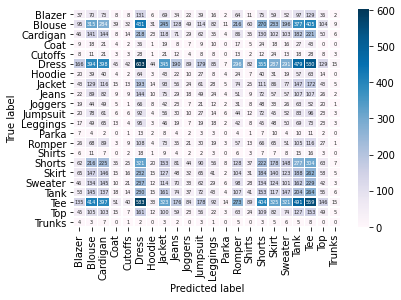

In [43]:
confusion_mat = confusion_mat(Y_pred_list, valY_labels, class_labels_sampling)
# print(classification_report)

In [1]:
model.load_weights('/home/azure/passion/AI/Demo/output/checkpoint/resnet50_model.ckpt')

loss, acc = model.evaluate(validation_generator)
print("loss: ", loss)
print("acc: ", acc)

NameError: name 'model' is not defined

### 17. Conversion to tensorflow lite

In [48]:
# Tensorflow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open('/home/azure/passion/AI/Demo/output/resnet50_model_serving.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp0pgpjmm_/assets


59965344